<a href="https://colab.research.google.com/github/KozinIS/CV/blob/main/12_%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B8%D0%B3%D1%80%D0%B5_%D0%B2_%D0%BF%D0%B8%D0%BD%D0%B3_%D0%BF%D0%BE%D0%BD%D0%B3_(DQN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Обучение игре в пинг-понг (DQN)**

# 1 Постановка задачи

*1. Подготовьте и обучите нейронную сеть, предназначенную для игры в пинг-понг.Сравните результаты (количество выигранных очков) после различного количества тренировок (10, 20, 30)*

*2. Проведите небольшую тренировочную сессию, изменив архитектуру нейросети:*

*- изменив количество связей в Dense слое;*

*- добавив Dense слой;*

*- добавив Conv слой.*

  *Результаты сравните.*


*3. Постарайтесь обучить нейросеть до уровня игры, равного сопернику (в идеале, до победы). Результат можно достичь большим количеством тренировок. Зафиксируйте какое количество тренировок/эпох и реального времени потребовалось нейросети для обучения.*


# 2 Подгрузка библиотек и подключение диска

In [ ]:
pip install tensorflow==1.15

In [ ]:
pip install keras==2.3

In [ ]:
import gym         # загружаем "тренажер" Gym из платформы OpenAi, предоставляющий среду для работы над обучением с подкреплением
import numpy as np # импортируем библиотеку для работы с массивами данных
import pandas as pd
import keras       # импортируем нейросетевую библиотеку
from keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply, Conv1D, Dropout # из кераса загружаем необходимые слои для нейросети
from keras.optimizers import RMSprop, Adam # из кераса загружаем выбранный оптимизатор
import time                                # модуль для операций со временными характеристиками
import matplotlib.pyplot as plt            # импортируем библиотеку для визуализации данных

# "магическая" команда python для запуска библиотеки в ноутбуке
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4 Краткий обзор игры

In [ ]:
env = gym.make('Pong-v0') # создаем среду игры Понг средствами OpenAI Gym('env' = environment)
observation = env.reset() # задаем начальное состояние среды, которое наблюдает агент
observation.shape         # взглянем на форму состояния среды
                          # увидим, что это изображение размером 210*160 с тремя RGB каналами

(210, 160, 3)

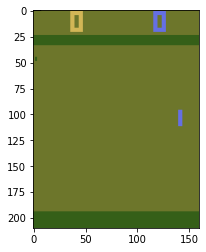

In [ ]:
plt.imshow(observation) # вызовем визуализацию состояния среды с помощью метода imshow от matplotlib.pyplot
plt.show()

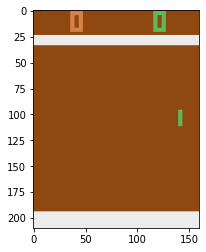

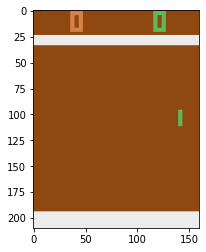

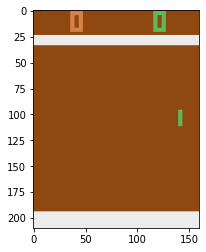

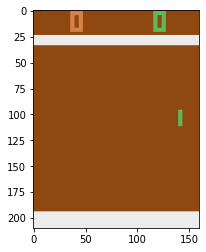

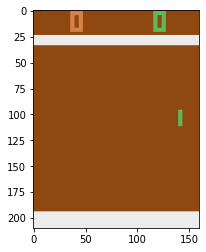

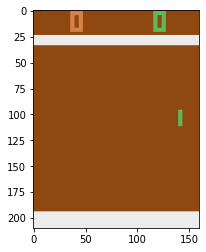

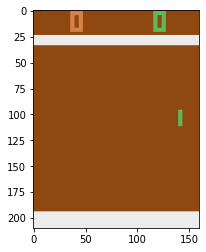

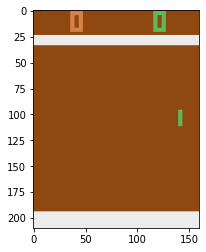

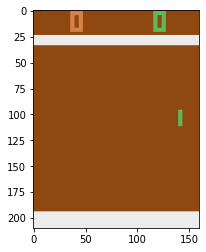

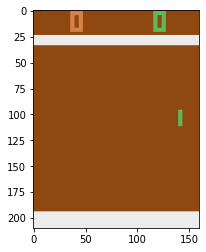

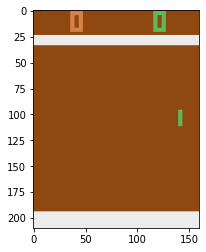

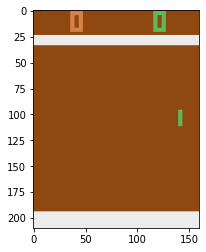

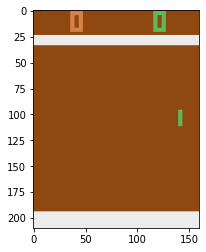

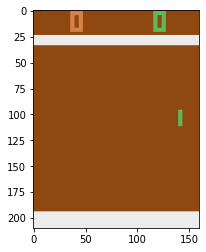

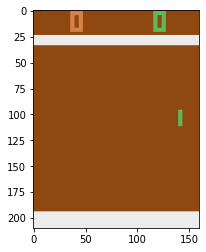

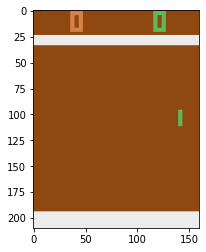

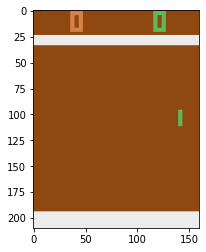

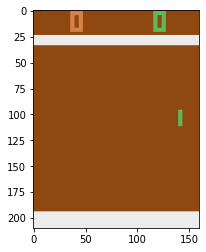

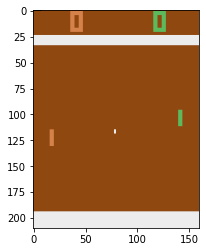

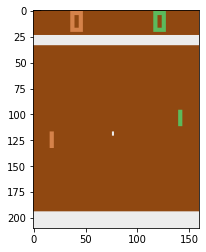

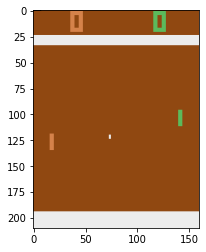

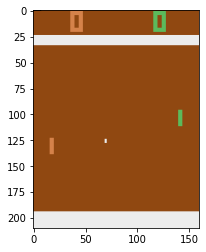

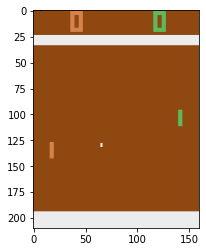

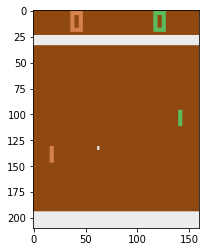

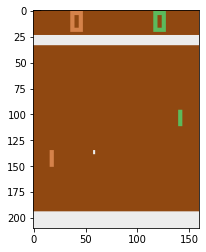

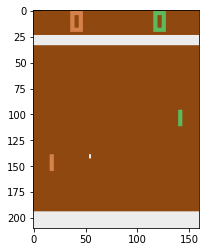

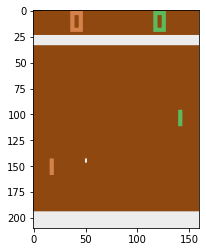

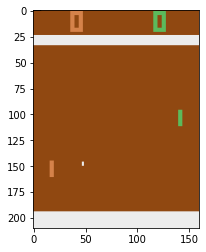

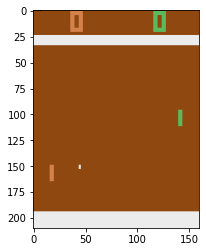

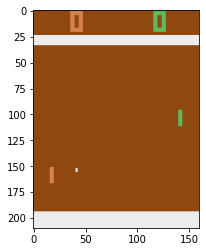

In [ ]:
# В понге:
# 0 цифровое обозначение если ракетка 'остаётся на месте'
# 2 цифровое обозначение для действия ракеткой 'сдвинуться вверх'
# 3 цифровое обозначение для действия ракеткой 'сдвинуться вниз'

# Проиграем вперёд игру на 30 кадров чтобы увидеть полную сцену игры
for i in range(30):
    observation, reward, done, info = env.step(0) # 0 обозначает,что ничего не делаем, остаемся на месте
    plt.imshow(observation)                       # взглянем на текущее состояние среды: наш агент владеет зелёной ракеткой, появился соперник и мяч
    plt.show()
# step - такт, шаг в игре: принимает (action, действие агента), возвращает кортеж (observation, reward, done, info)
# observation (object) - текущее состояние среды, которое наблюдает агент(пиксели)
# reward (float) - награда за совершённое действие
# done (True or False) - обозначает завершился ли игровой эпизод (в понге до победы 21 очко)
# info (dict) - вспомогательная диагностическая информация, типа кол-во оставшихся жизней(неактуально для понга)

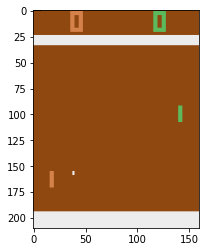

In [ ]:
# Policy(политику, стратегию агента) будет позже задавать нейросеть.
# мы подадим ей разницу между новым и предыдущим кадром, чтобы отслеживалось смещение мяча/ракеток и данные были понятными
newObservation, reward, done, info = env.step(2) # задаем очередным шагом следующий кадр, при этом смещая ракетку вверх
plt.imshow(newObservation)                       # взглянем на следующий кадр(нам смещение едва видно, либо не видно, т.к визуально длина шага мала)

# 5 Предобработка данных

In [ ]:
# Зададим функцию предобработки данных для подачи в нейросеть
# избавимся от всего лишнего(фон, размер и т.п), оставив на экране лишь мяч и ракетки
def preprocessFrames(newFrame,lastFrame): # подаем в функцию новый и предыдущий кадр
  nFrame = newFrame.astype(np.int32)      # переводим в целочисленный тип новый кадр
  lFrame = lastFrame.astype(np.int32)     # переводим в целочисленный тип предыдущий кадр
  deltaFrame = nFrame - lFrame            # задаём разницу между новым и предыдущим кадром
  # Отрезаем верхнюю и нижнюю(неинформативные) части экрана, по 35 сверху и снизу
  deltaFrame = deltaFrame[35:195]         # срезали края по высоте, осталась картинка 160*160
  # Делаем сжатие кадра в 2 раза по обеим сторонам изображения и оставляем монотонный канал
  deltaFrame=deltaFrame[::2,::2, 0]
  # Масштабирование чисел от 0 до 1
  maxValue = deltaFrame.max() if deltaFrame.max()> abs(deltaFrame.min()) else abs(deltaFrame.min())
  if maxValue != 0:
      deltaFrame=deltaFrame/maxValue
  return deltaFrame                       # функция вернет разницу между кадрами в оптимальном виде

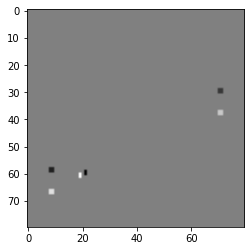

In [ ]:
plt.imshow(preprocessFrames(newObservation, observation), plt.cm.gray) # выведем результат предобработки наших кадров

In [ ]:
preprocessFrames(newObservation, observation) # выведем массив для этого состояния среды(кадра)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
preprocessFrames(newObservation, observation).shape # выведем форму массива

(80, 80)

In [ ]:
# Cостоянием среды будет картинка 80*80, полученная вычитанием двух последовательных кадров, где по итогу все будет...
# ...заполнено нулями, а в местах смещения мяча либо ракетки - ненулевые значения.
# Далее keras'ом создадим policy, которая на основе состояния(картинки) выбирает действия.
# Output сети - вероятность того что нужно двигаться вверх

# 6 Подготовка нейросетей

## 6.1 Нейросеть № 1 (эталонная, с занятия)

In [ ]:
# Простая модель с двумя слоями, на 200 нейронов в скрытом слое и сигмоидой на выходе
inputs = Input(shape=(80,80))      # на входном слое сетки изображение 80*80
flattenedLayer = Flatten()(inputs) # перевели в вектор
fullConnected = Dense(units=200, activation='relu', use_bias=False)(flattenedLayer) # задали 200 нейронов и активацию релу
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(fullConnected)       # сигмоида на выходе
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)                    # собрали модель стратегии(Model - абстрактный класс базовой модели)
policyNetworkModel.summary()       # посмотрим на модель

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 80, 80)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 200)               1280000   
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


## 6.2 Нейросеть № 2 (с изменённым количеством связей в Dense-слое)

In [ ]:
inputs = Input(shape=(80,80))
flattenedLayer_2 = Flatten()(inputs)
fullConnected_2 = Dense(units=200, activation='relu', use_bias=False)(flattenedLayer_2)
Dropout_2 = Dropout(0.3) (fullConnected_2)                                                     # Добавлен слой Dropout(0.3)
sigmoidOutput_2 = Dense(1, activation='sigmoid', use_bias=False)(Dropout_2)
policyNetworkModel_2 = Model(inputs=inputs, outputs=sigmoidOutput_2)
policyNetworkModel_2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               1280000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


## 6.3 Нейросеть № 3 (с увеличенным количеством нейронов в Dense-слое)

In [ ]:
inputs = Input(shape=(80,80))
flattenedLayer_3 = Flatten()(inputs)
fullConnected_3 = Dense(units=400, activation='relu', use_bias=False)(flattenedLayer_3)        # Увеличено количество Dense-слоёв до 400
Dropout_3 = Dropout(0.3) (fullConnected_3)                                                     # Добавлен слой Dropout(0.3)
sigmoidOutput_3 = Dense(1, activation='sigmoid', use_bias=False)(Dropout_3)
policyNetworkModel_3 = Model(inputs=inputs, outputs=sigmoidOutput_3)
policyNetworkModel_3.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 80, 80)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 400)               2560000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 400       
Total params: 2,560,400
Trainable params: 2,560,400
Non-trainable params: 0
_________________________________________________________________


## 6.4 Нейросеть № 4 (с дополнительным Dense-слоем)

In [ ]:
inputs = Input(shape=(80,80))
flattenedLayer_4 = Flatten()(inputs)
fullConnected_4_1 = Dense(units=200, activation='relu', use_bias=False)(flattenedLayer_4)
fullConnected_4_2 = Dense(units=200, activation='relu', use_bias=False)(fullConnected_4_1)        # добавлен слой Dense(200)
sigmoidOutput_4 = Dense(1, activation='sigmoid', use_bias=False)(fullConnected_4_2)
policyNetworkModel_4 = Model(inputs=inputs, outputs=sigmoidOutput_4)
policyNetworkModel_4.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 80, 80)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)               1280000   
_________________________________________________________________
dense_22 (Dense)             (None, 200)               40000     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 200       
Total params: 1,320,200
Trainable params: 1,320,200
Non-trainable params: 0
_________________________________________________________________


## 6.5 Нейросеть № 5 (с Conv-слоями)

In [ ]:
inputs = Input(shape=(80,80))
Conv1DLayer__5_1 = (Conv1D(40, 5, padding = 'same', activation = 'relu'))(inputs)            # добавлен слой Conv1D
Conv1DLayer__5_2 = (Conv1D(40, 5, padding = 'same', activation = 'relu'))(Conv1DLayer__5_1)  # добавлен слой Conv1D
flattenedLayer_5 = Flatten()(Conv1DLayer__5_2)
fullConnected_5_1 = Dense(units=200, activation='relu', use_bias=False)(flattenedLayer_5)
sigmoidOutput_5 = Dense(1, activation='sigmoid', use_bias=False)(fullConnected_5_1)
policyNetworkModel_5 = Model(inputs=inputs, outputs=sigmoidOutput_5)
policyNetworkModel_5.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 80, 80)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 80, 40)            16040     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 80, 40)            8040      
_________________________________________________________________
flatten_15 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 200)               640000    
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 200       
Total params: 664,280
Trainable params: 664,280
Non-trainable params: 0
____________________________________________________

# 7 Подготовка функции потерь в соответствии с изображением

In [ ]:
# episode - одна тренировочная игра от начала партии до перезагрузки (розыгрыш эпизода до 21 очка; после победы или поражения вызываем reset)
episodeReward = Input(shape=(1,), name='episodeReward') # задаем награду за эпизод

In [ ]:
###########################
# Функция потерь в керасе имеет вид def loss(yTrue,yPred):...А так как нам нужно включить reward в loss, создаем...
# ...функцию rewardedLoss поверх неё, чтобы на входе добавить episodeReward
###########################
def rewardedLoss(episodeReward): # задаем новую функцию потерь, принимающую episodeReward, награда
  def loss(yTrue,yPred):
    # подаём в кач-ве yTrue фактически сделанное действие(action)
    # если фактически сделанное действие было движением вверх - подаем 1 на yTrue, если нет то подаем 0
    # yPred - выход сетки(вероятность выбора движения вверх)
    # мы не подаём yPred в нейронку, его вычисляет керас

    # сначала log(0) and log(1) неопределены - загоняем yPred между значениями:
    tmpPred = Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(yPred)
    # вычисляем логарифм вероятности. yPred - вероятность выбора движения вверх
    # помним что yTrue = 1 когда фактически выбрано движение вверх, и 0 - когда вниз
    # формула похожа на кросс-энтропию в керасе, но здесь мы прописываем её вручную, чтобы умножить на значение награды
    tmpLoss = Lambda(lambda x:-yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
    # обновленная функция потерь - "функция политики"
    policyLoss = Multiply()([tmpLoss, episodeReward]) #добавляем в loss умножение на награду за эпизод
    return policyLoss # ввели обновленную функцию политики
  return loss         # возвращаем обновленную функцию политики

In [ ]:
###########################
# Создаем керас-оптимизатор и нейронку для обучения
###########################
episodeReward = Input(shape=(1,), name='episodeReward')                             # задаем награду за эпизод
policyNetworkTrain = Model(inputs=[inputs, episodeReward],outputs=sigmoidOutput)    # задаем сеть с добавлением на вход награды

myOptimizer = RMSprop(lr=0.0001)                                                    # выбрали оптимизатор с заданной скоростью обучения
policyNetworkTrain.compile(optimizer=myOptimizer, loss=rewardedLoss(episodeReward)) # задаем сеть с новой функцией потерь policy

# 8 Генерация игрового эпизода

In [ ]:
###########################
# Создадим функцию, которая будет генерировать игровой эпизод с участием нейросети
###########################
#игра начнется с того, что в новом эпизоде наш агент сделает движение("actualAction") вверх с вероятностью(upProbability), которую предсказала наша...
#...сетка policyNetwork, принявшая на вход состояние среды reshapedInput с подбитой под сеть формой.
#reshapedInput же получили из состояния processedNetworkInput, которое представляет собой разницу в кадрах между новым и предыдущим...
#...кадром, полученную функцией preprocessFrames.


def generateEpisode(policyNetwork): # подаем на вход функции модель нейросети
  statesList = []                   # список состояний в течение эпизода, размер = (x,80,80)
  upDownActionList=[]               # список движений в течение эпизода: вверх - 1, вниз - 0
  rewardsList=[]                    # список наград за каждое действие
  networkOutputList=[]              # на выходе нейросети - вероятность что нужно идти вверх; собираем список из вероятности на каждом шаге
  env=gym.make("Pong-v0")           # cоздали среду
  observation = env.reset()         # перезагрузили состояние среды
  newObservation = observation      # получили новое состояние, которое наблюдает агент
  done = False                      # игровой эпизод активен(не завершён)

  while done == False: # пока игровой эпизод не завершён
    # На вход сети будет подаваться очередное состояние - разница между кадрами.
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation) # зададим это состояние
    statesList.append(processedNetworkInput) # добавим в список состояний (впоследствие станет 'x'ом для входа в нейронку)
    reshapedInput = np.expand_dims(processedNetworkInput, axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))

    upProbability = policyNetwork.predict(reshapedInput, batch_size=1)[0][0] # задаем вероятность шага вверх
    networkOutputList.append(upProbability) # добавляем к списку из вероятности идти вверх на каждом шаге
    actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability, 1-upProbability])
    # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью

    if actualAction == 2:        # если пошли вверх
      upDownActionList.append(1) # добавляем единицу в список движений в течение эпизода
    else:                        # если не пошли вверх
      upDownActionList.append(0) # то добавляем ноль

    observation = newObservation # текущий newObservation записываем как старый перед тем, как сделать следующий шаг
    newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние

    rewardsList.append(reward)   # добавили текущую награду в список

    if done: # если игровой эпизод закончен
      break  # завершаем цикл

  env.close() # закрываем текущую среду
  return statesList, upDownActionList, rewardsList, networkOutputList
  # функция возвращает: список состояний в течение эпизода,список движений в течение эпизода, список наград за каждое действие,
  # и список вероятностей того, что нужно идти вверх

In [ ]:
###########################
# Сгенерируем эпизод игры с необученной сетью
###########################
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("----------------------")
print("Количество состояний в эпизоде = "+str(len(statesList))) # количество состояний (кадров) в эпизоде
print("Форма состояния "+str(statesList[0].shape))              # форма каждого состояния
print("Количество наград за эпизод = "+str(len(rewardsList)))   # количество наград за эпизод(включая нулевые награды)


----------------------
Количество состояний в эпизоде = 1664
Форма состояния (80, 80)
Количество наград за эпизод = 1664


In [ ]:
# Взглянем на фрагмент списка из вероятности идти вверх на каждом шаге.
print(networkOutputList[50:70])
# увидим что на каждом шаге вероятность крутится около 50% - сеть пока не понимает куда лучше шагать

[0.49706706, 0.5097563, 0.5153659, 0.48820502, 0.50611407, 0.48780534, 0.49822438, 0.522496, 0.5137297, 0.5014538, 0.52652144, 0.50406194, 0.49822065, 0.4845047, 0.5220453, 0.50202036, 0.5158634, 0.51685363, 0.51594317, 0.4978446]


In [ ]:
# Взглянем на фактические действия: 1 - вверх, 0 - вниз
upDownActionList[50:70]
# Соответственно шаги также были случайными

[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]

In [ ]:
# Выведем список наград(почти везде нули, кроме тех моментов когда выигрываем или проигрываем очко)
print(rewardsList[50:70])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# Взглянем на то, сколько мы раз выиграли в течение эпизода:
print("Количество выигранных очков = "+str(len(list(filter(lambda r: r>0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,большим 0
print("Количество проигранных очков = "+str(len(list(filter(lambda r: r<0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,меньшим 0
print("Количество нулевых наград = "+str(len(list(filter(lambda r: r==0,rewardsList))))) #с фильтром по 0

Количество выигранных очков = 0
Количество проигранных очков = 21
Количество нулевых наград = 1643


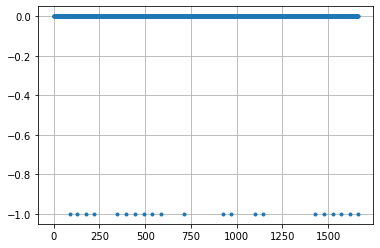

In [ ]:
# Выведем на графике полученные награды. Ненулевые награды за каждое очко будут отмечены точками.
plt.plot(rewardsList, '.') # точки будут наградами на графике
ax=plt.gca()               # получим текущие оси
ax.grid(True)              # с фоновой сеткой

# 9 Определение вознаграждения

In [ ]:
# Награды пока присуждаются только тем движениям, в момент после которых было пропущено или забито очко. Но так мы научимся нескоро,
# нам нужно указать на важность действия чуть ранее, когда мы отбивали мяч ракеткой. Чтобы сетка поняла что отбивать мяч - это хорошо,
# распределим награду на все шаги, предшествующие забитому/пропущеному мячу, причем чем давнее был шаг, тем меньший коэффициент награды он получит.

###########################
# Сформулируем функцию, которая распределит ненулевую награду для всех шагов в удачном/неудачном розыгрыше
###########################
def processRewards(rewardList): # подадим в функцию список наград
  rewardDecay = 0.99            # установим высший коэффициент награды для ближнего действия к победному/проигрышному действию
  tmpReward = 0                 # создадим временную переменную для награды
  rewardDecayed = np.zeros_like(rewardList,dtype=np.float32) # создадим массив из нулей для нового формата наград
  for i in range(len(rewardList)-1,-1,-1): # будем идти в обратную сторону от награды с шагом "-1"
    if rewardList[i] == 0:                 # если награда нулевая
      tmpReward = tmpReward*rewardDecay    # зададим ей коэффициент
      rewardDecayed[i] = tmpReward         # и добавим в массив
    else:                                  # иначе
      tmpReward = rewardList[i]            # оставим награду неизменной
      rewardDecayed[i] = tmpReward         # и введём в том же виде в массив
  # запустим нормализацию значений наград, что позволит сетке лучше понимать, где были хорошие и плохие шаги
  rewardDecayed -= np.mean(rewardDecayed)  # вычтем среднее
  rewardDecayed /= np.std(rewardDecayed)   # разделим на стандартное отклонение
  return rewardDecayed
  # функция возвращает обновленный формат наград

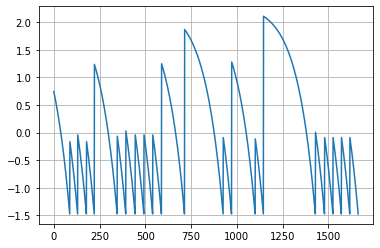

In [ ]:
# Посмотрим на распределение наград по новой функции
plt.plot(processRewards(rewardsList),'-') # добавляем в график награды с учетом новой функции
ax = plt.gca() # получим текущие оси
ax.grid(True)  # с фоновой сеткой
# новое распределение наград даст лучшее отражение эффективности действий

# 10 Пример игрового эпизода с последующей тренеровкой нейросети

In [ ]:
# Сгенерируем новый игровой эпизод:
statesList,upDownActionList,rewardsList,networkOutputList = generateEpisode(policyNetworkModel)
# сыграли до 21 очка, проиграли, получили списки всех состояний среды(кадров), шагов агента, вознаграждений и предсказаний

print("Количество состояний среды = "+str(len(statesList))) # выведем количество состояний среды(кадров) в игровом эпизоде
print("Форма состояний среды = "+str(statesList[0].shape))  # выведем форму для каждого состояния
print("Список наград  = "+str(len(rewardsList)))            # выведем список наград в игровом эпизоде(включая нулевые)

Количество состояний среды = 1259
Форма состояний среды = (80, 80)
Список наград  = 1259


In [ ]:
# Подготовим данные для тренировки
x = np.array(statesList)          # зададим 'x' как массив состояний
episodeReward = np.expand_dims(processRewards(rewardsList), 1) # подобьем размер для входа в сетку
yTmp = np.array(upDownActionList) # зададим 'y' как список движений вверх(1)/вниз(0)
yTrue = np.expand_dims(yTmp, 1)   # скорректируем форму под сетку


print("Форма наград за эпизод =", episodeReward.shape) # выведем форму наград за эпизод
print("Форма состояний среды =", x.shape)              # выведем форму состояний среды ('x' для нейросети)
print("Форма фактических движений =", yTrue.shape)     # выведем форму фактических движений ('y' для нейросети)

Форма наград за эпизод = (1259, 1)
Форма состояний среды = (1259, 80, 80)
Форма фактических движений = (1259, 1)


In [ ]:
episodeReward[:20]

array([[1.6153928],
       [1.5919933],
       [1.5683575],
       [1.5444831],
       [1.5203674],
       [1.496008 ],
       [1.4714026],
       [1.4465487],
       [1.4214438],
       [1.3960853],
       [1.3704708],
       [1.3445972],
       [1.3184625],
       [1.2920637],
       [1.2653984],
       [1.2384636],
       [1.2112567],
       [1.1837751],
       [1.156016 ],
       [1.1279763]], dtype=float32)

In [ ]:
# "Скормим" модели новые 'x' и 'y'
policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1
1259/1259 [==============================] - 0s 145us/step - loss: -9.6419e-04


In [ ]:
###########################
# Теперь создадим серию игровых эпизодов
# Затем предобработаем данные и скормим нейросети
###########################
def generateEpisodeBatchesTraining(model, nBatches=10): # подаем на вход заданное количество игровых серий
  env = gym.make('Pong-v0')                             # создаем игровую среду Pong
  batchStateList = []                                   # зададим серию списков состояний
  batchUpDownActionList = []                            # зададим серию списков движений
  batchRewardsList = []                                 # зададим серию списков наград
  batchNetworkOutputList = []                           # зададим серию списков из вероятности идти вверх
  for i in range(nBatches):                             # для каждой серии
    statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model) # сгенерируем игровой эпизод
    batchStateList.extend(statesList)                   # добавим список состояний в серию списков состояний
    batchNetworkOutputList.extend(networkOutputList)    # добавим список вероятностей в серию списков из вероятности идти вверх
    batchUpDownActionList.extend(upDownActionList)      # добавим список движений в серию списков движений
    batchRewardsList.extend(rewardsList)                # добавим список наград в серию списков наград

  episodeReward = np.expand_dims(processRewards(batchRewardsList), 1) # зададим награды и изменим форму массива с добавлением оси
  x = np.array(batchStateList)                          # сформируем массив из серии списков состояний в качестве 'x' для нейросети
  yTmp = np.array(batchUpDownActionList)                # зададим 'y' как серию из списков движений вверх(1)/вниз(0)
  yTrue = np.expand_dims(yTmp, 1)                       # подгоним форму 'y' массива с добавлением оси

  history = policyNetworkTrain.fit(x=[x,episodeReward], y=yTrue, epochs=5, verbose=0) # скормим нейросети серию 'x'ов и 'y'ов

  batchLoss = history.history['loss'][-1]
  return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss
  # функция вернёт серию списков состояний, серию списков движений, серию списков наград, серию списков из вероятности идти вверх

In [ ]:
 !nvidia-smi

Sun Feb  7 09:03:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |    513MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 11 Обучение нейросетей на серии из 30-ти игровых эпизодов

## 11.1 Нейросеть № 1 (эталонная, с занятия)

In [ ]:
trainingTimes = 31                   # указано 31, а не 30, чтобы сохранились веса. Иначе после 30 не сохраняются.
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("/content/drive/MyDrive/HW_32/policyNetworkModel.h5")                   # сохраним модель на диске
    policyNetworkModel.save("/content/drive/MyDrive/HW_32/policyNetworkModel" + str(training)+".h5")# и для удобства сохраним модель на диске
    with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 58сек
Ошибка на тренировке = -0.10498
Выиграли очков = 45 Проиграли очков = 210

Тренировка = 2
Время тренировки = 68сек
Ошибка на тренировке = -0.05706
Выиграли очков = 29 Проиграли очков = 210

Тренировка = 3
Время тренировки = 54сек
Ошибка на тренировке = -0.07654
Выиграли очков = 18 Проиграли очков = 210

Тренировка = 4
Время тренировки = 70сек
Ошибка на тренировке = -0.06544
Выиграли очков = 30 Проиграли очков = 210

Тренировка = 5
Время тренировки = 76сек
Ошибка на тренировке = -0.06175
Выиграли очков = 38 Проиграли очков = 210

Тренировка = 6
Время тренировки = 76сек
Ошибка на тренировке = -0.08194
Выиграли очков = 44 Проиграли очков = 210

Тренировка = 7
Время тренировки = 76сек
Ошибка на тренировке = -0.0824
Выиграли очков = 53 Проиграли очков = 210

Тренировка = 8
Время тренировки = 68сек
Ошибка на тренировке = -0.08975
Выиграли очков = 57 Проиграли очков = 210

Тренировка = 9
Время тренировки = 69сек
Ошибка на тренировке = -0.08597
Выиграли 

## 11.2 Нейросеть № 2 (с изменённым количеством связей в Dense-слое)

In [ ]:
trainingTimes = 31                   # установим количество тренировок
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel_2, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel_2.save("/content/drive/MyDrive/HW_32/policyNetworkModel_2.h5")                   # сохраним модель на диске
    policyNetworkModel_2.save("/content/drive/MyDrive/HW_32/policyNetworkModel_2_" + str(training)+".h5")# и для удобства сохраним модель на диске
    with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 35сек
Ошибка на тренировке = -0.0537
Выиграли очков = 7 Проиграли очков = 210

Тренировка = 2
Время тренировки = 37сек
Ошибка на тренировке = -0.08618
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 3
Время тренировки = 38сек
Ошибка на тренировке = -0.04712
Выиграли очков = 3 Проиграли очков = 210

Тренировка = 4
Время тренировки = 38сек
Ошибка на тренировке = -0.0746
Выиграли очков = 7 Проиграли очков = 210

Тренировка = 5
Время тренировки = 38сек
Ошибка на тренировке = -0.06166
Выиграли очков = 7 Проиграли очков = 210

Тренировка = 6
Время тренировки = 36сек
Ошибка на тренировке = -0.08717
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 7
Время тренировки = 37сек
Ошибка на тренировке = -0.06676
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 8
Время тренировки = 34сек
Ошибка на тренировке = -0.03395
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 9
Время тренировки = 36сек
Ошибка на тренировке = -0.07758
Выиграли очков = 5

## 11.3 Нейросеть № 3 (с увеличенным количеством нейронов в Dense-слое)

In [ ]:
trainingTimes = 31                   # установим количество тренировок
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel_3, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel_3.save("/content/drive/MyDrive/HW_32/policyNetworkModel_3.h5")                   # сохраним модель на диске
    policyNetworkModel_3.save("/content/drive/MyDrive/HW_32/policyNetworkModel_3_" + str(training)+".h5")# и для удобства сохраним модель на диске
    with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 38сек
Ошибка на тренировке = -0.03001
Выиграли очков = 7 Проиграли очков = 210

Тренировка = 2
Время тренировки = 35сек
Ошибка на тренировке = -0.06384
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 3
Время тренировки = 37сек
Ошибка на тренировке = -0.08374
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 4
Время тренировки = 40сек
Ошибка на тренировке = -0.06763
Выиграли очков = 10 Проиграли очков = 210

Тренировка = 5
Время тренировки = 35сек
Ошибка на тренировке = -0.08924
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 6
Время тренировки = 37сек
Ошибка на тренировке = -0.08557
Выиграли очков = 3 Проиграли очков = 210

Тренировка = 7
Время тренировки = 33сек
Ошибка на тренировке = -0.10213
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 8
Время тренировки = 37сек
Ошибка на тренировке = -0.09384
Выиграли очков = 9 Проиграли очков = 210

Тренировка = 9
Время тренировки = 39сек
Ошибка на тренировке = -0.08234
Выиграли очков 

## 11.4 Нейросеть № 4 (с дополнительным Dense-слоем)

In [ ]:
trainingTimes = 31                   # установим количество тренировок
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel_4, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel_4.save("/content/drive/MyDrive/HW_32/policyNetworkModel_4.h5")                   # сохраним модель на диске
    policyNetworkModel_4.save("/content/drive/MyDrive/HW_32/policyNetworkModel_4_" + str(training)+".h5")# и для удобства сохраним модель на диске
    with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 40сек
Ошибка на тренировке = -0.08739
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 2
Время тренировки = 41сек
Ошибка на тренировке = -0.07684
Выиграли очков = 11 Проиграли очков = 210

Тренировка = 3
Время тренировки = 37сек
Ошибка на тренировке = -0.11101
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 4
Время тренировки = 36сек
Ошибка на тренировке = -0.11366
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 5
Время тренировки = 39сек
Ошибка на тренировке = -0.09239
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 6
Время тренировки = 36сек
Ошибка на тренировке = -0.118
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 7
Время тренировки = 39сек
Ошибка на тренировке = -0.08041
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 8
Время тренировки = 38сек
Ошибка на тренировке = -0.09272
Выиграли очков = 7 Проиграли очков = 210

Тренировка = 9
Время тренировки = 41сек
Ошибка на тренировке = -0.09265
Выиграли очков = 

## 11.5 Нейросеть № 5 (с Conv-слоем)

In [ ]:
trainingTimes = 31                   # установим количество тренировок
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel_5, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel_5.save("/content/drive/MyDrive/HW_32/policyNetworkModel_5.h5")                   # сохраним модель на диске
    policyNetworkModel_5.save("/content/drive/MyDrive/HW_32/policyNetworkModel_5_" + str(training)+".h5")# и для удобства сохраним модель на диске
    with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 39сек
Ошибка на тренировке = -0.09776
Выиграли очков = 9 Проиграли очков = 210

Тренировка = 2
Время тренировки = 38сек
Ошибка на тренировке = -0.10035
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 3
Время тренировки = 36сек
Ошибка на тренировке = -0.14135
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 4
Время тренировки = 37сек
Ошибка на тренировке = -0.14612
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 5
Время тренировки = 38сек
Ошибка на тренировке = -0.13852
Выиграли очков = 3 Проиграли очков = 210

Тренировка = 6
Время тренировки = 37сек
Ошибка на тренировке = -0.10393
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 7
Время тренировки = 38сек
Ошибка на тренировке = -0.12
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 8
Время тренировки = 36сек
Ошибка на тренировке = -0.14314
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 9
Время тренировки = 37сек
Ошибка на тренировке = -0.11909
Выиграли очков = 3 

## 11.6 Нейросеть № 6 (сеть № 1 + 120 тренировок)

In [ ]:
trainingTimes = 121                   # установим количество тренировок
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training == 120:
    policyNetworkModel_6.save("/content/drive/MyDrive/HW_32/policyNetworkModel_6.h5")                   # сохраним модель на диске
    policyNetworkModel_6.save("/content/drive/MyDrive/HW_32/policyNetworkModel_6_120.h5")# и для удобства сохраним модель на диске
    with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 54сек
Ошибка на тренировке = -0.01114
Выиграли очков = 9 Проиграли очков = 210

Тренировка = 2
Время тренировки = 56сек
Ошибка на тренировке = -0.03087
Выиграли очков = 9 Проиграли очков = 210

Тренировка = 3
Время тренировки = 59сек
Ошибка на тренировке = -0.03034
Выиграли очков = 16 Проиграли очков = 210

Тренировка = 4
Время тренировки = 61сек
Ошибка на тренировке = -0.03785
Выиграли очков = 18 Проиграли очков = 210

Тренировка = 5
Время тренировки = 63сек
Ошибка на тренировке = -0.04326
Выиграли очков = 24 Проиграли очков = 210

Тренировка = 6
Время тренировки = 62сек
Ошибка на тренировке = -0.04547
Выиграли очков = 28 Проиграли очков = 210

Тренировка = 7
Время тренировки = 59сек
Ошибка на тренировке = -0.03908
Выиграли очков = 19 Проиграли очков = 210

Тренировка = 8
Время тренировки = 67сек
Ошибка на тренировке = -0.04129
Выиграли очков = 29 Проиграли очков = 210

Тренировка = 9
Время тренировки = 68сек
Ошибка на тренировке = -0.05682
Выиграли о

# 12 Демонстрация работы обученных нейросетей

## 12.1 Общие положения

In [ ]:
###########################
# Импорт библиотек для записи и воспроизведения видео
###########################
!pip install pyvirtualdisplay > /dev/null 2>&1
# Устанавливаем виртуальный дисплей pyvirtualdisplay; "/dev/null 2>&1" уберёт длинный вывод в строке output
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 # создает вирт.дисплей в памяти(нужен для работы дисплея в ноутбуке)
# "apt-get..." - установка пакета программного обеспечения
# "...-y..." автоматический "yes" на вопрос "вы действительно хотите это установить?"
# "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран
# "...python-opengl..." - поддержка графики с помощью графической библиотеки
# "...ffmpeg" - пакеты для обработки/конвертирования видеофайла из одного формата в другой

from gym.wrappers import Monitor # класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob   # модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64 # библиотека поможет нам закодировать видео в 64-разрядный код, и без повреждений/изменений открыть его в ноутбуке через HTML

from IPython.display import HTML              # загружаем модуль чтобы обратиться к HTML для открытия закодированного видео
from IPython import display as ipythondisplay # активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display          # модуль для активации виртуального дисплея
display = Display(visible=0, size=(1400, 900))# запустим невидимый виртуальный дисплей
display.start()

In [ ]:
###########################
# Задаем функции записи и воспроизведения видео
###########################
def wrapEnv(env):                           # зададим функцию-обёртку над средой
  env = Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
  return env                                # теперь вызов среды через функцию wrapEnv будет запускать видеозапись

def showVideo():                            # функция для воспроизведения видео в ноутбуке
  mp4list = glob.glob('video/*.mp4')        # возвращает список путей к видео по этому шаблону
  if len(mp4list) > 0:                      # если по этому пути нашелся хотя бы один файл
    mp4 = mp4list[0]                        # то берём самый свежий файл
    video = open(mp4, 'r+b').read()         # открываем в режиме чтения/записи бинарного файла
    encoded = base64.b64encode(video)       # кодируем видео в 64-разрядный код
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео(типа кнопки паузы и т.п) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива описывающая объект в случае невозможности отображения - "alt="test""

  else:                           # если путь не нашелся
    print("Could not find video") # то выведем на печать, что не смог найти видео

In [ ]:
###########################
# Задаем функцию сыграть и показать игру
###########################
def playAndShowEpisode(policyNetwork): # подаем на вход функции модель нейросети
    env = wrapEnv(gym.make('Pong-v0')) # создаем среду в режиме записи
    done = False                       # игровой эпизод не завершён
    observation = env.reset()          # задаем начальное состояние среды, которое наблюдает агент
    newObservation = observation       # задали новое состояние которое наблюдает агент
    while done == False:               # пока игровой эпизод не завершён
        # На вход сети будет подаваться очередное состояние - разница между кадрами.
        processedNetworkInput = preprocessFrames(newFrame=newObservation,lastFrame=observation) # зададим это состояние
        reshapedInput = np.expand_dims(processedNetworkInput,axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))

        upProbability = policyNetwork.predict(reshapedInput,batch_size=1)[0][0] # задаем вероятность шага вверх
        actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability,1-upProbability])
        # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью

        env.render()                   # запускаем воспроизведение среды

        observation = newObservation   # текущий newObservation записываем как старый, перед тем как сделать следующий шаг
        newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние

    env.close() # закрываем игровую среду после окончания игры
    showVideo() # показать видео игры

In [ ]:
playAndShowEpisode(policyNetworkModel) # запускаем игровой эпизод c необученной моделью нейросети

## 12.2 Проверка работы нейросетей

**Нейросеть № 1 (эталонная, с занятия)**

In [ ]:
policyNetworkModel30 = load_model("/content/drive/MyDrive/HW_32/policyNetworkModel30.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel30)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


**Нейросеть № 2 (с изменённым количеством связей в Dense-слое)**

In [ ]:
policyNetworkModel_2_30 = load_model("/content/drive/MyDrive/HW_32/policyNetworkModel_2_30.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel_2_30)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


**Нейросеть № 3 (с увеличенным количеством нейронов в Dense-слое)**

In [ ]:
policyNetworkModel_3_30 = load_model("/content/drive/MyDrive/HW_32/policyNetworkModel_3_30.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel_3_30)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


**Нейросеть № 4 (с дополнительным Dense-слоем)**

In [ ]:
policyNetworkModel_4_30 = load_model("/content/drive/MyDrive/HW_32/policyNetworkModel_4_30.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel_4_30)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


**Нейросеть № 5 (с Conv-слоем)**

In [ ]:
policyNetworkModel_5_30 = load_model("/content/drive/MyDrive/HW_32/policyNetworkModel_5_30.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel_5_30)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


**Нейросеть № 6 (со 120-ю тренировками)**

In [ ]:
policyNetworkModel_6_120 = load_model("/content/drive/MyDrive/HW_32/policyNetworkModel_6_120.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel_6_120)                     # запускаем игровой эпизод

# 1.12 Результаты

In [ ]:
results = {'Наименование': ['Нейросеть № 1', 'Нейросеть № 2', 'Нейросеть № 3', 'Нейросеть № 4', 'Нейросеть № 5', 'Нейросеть № 6'],
        'Добавленные слои': ['-', 'Dropout(0.3)', 'Dense(400), Dropout(0.3)', 'Dense(200)', 'Conv1D, Conv1D', '-'],
        'Количество проведённых тренеровок': [30, 30, 30, 30, 30, 97],
        'Примерная продолжительность одной тренировки (сек.)': [70, 35, 37, 38, 38, 70],
        'Значение ошибки после окончания тренировки': [-0.12775, -0.08836, -0.10804, -0.10029, -0.12916, -0.08235],
        'Очков выиграно / проиграно (после 30-й тренировки)': ['57/210', '4/210', '4/210', '7/210', '5/210', '60/210'],
        'Количество выигранных игр (случайных, до 21 очка)': [4, 1, 1, 0, 1, '?']}

results_base = pd.DataFrame(results)

In [ ]:
results_base.head(10)

,Наименование,Добавленные слои,Количество проведённых тренеровок,Примерная продолжительность одной тренировки (сек.),Значение ошибки после окончания тренировки,Очков выиграно / проиграно (после 30-й тренировки),"Количество выигранных игр (случайных, до 21 очка)"
0,Нейросеть № 1,-,30,70,-0.12775,57/210,4
1,Нейросеть № 2,Dropout(0.3),30,35,-0.08836,4/210,1
2,Нейросеть № 3,"Dense(400), Dropout(0.3)",30,37,-0.10804,4/210,1
3,Нейросеть № 4,Dense(200),30,38,-0.10029,7/210,0
4,Нейросеть № 5,"Conv1D, Conv1D",30,38,-0.12916,5/210,1
5,Нейросеть № 6,-,97,70,-0.08235,60/210,?


# 1.13 Выводы

Подготовлены шесть неёронных сетей, предназначенных для игры в пинг-понг. Сети были обучены на 31-й тренировке с фиксацией результатов после 30-и тренировок.

Наилучшие результаты продемонстрировала эталонная нейронная сеть, обученная на 97 тренировках. В состав этой сети не были внесены никакие изменения. Веса сети не были сохранены (в соответствии с заданным условием - сохранение после 120-й эпохи) и демонстрация работы обученной сети не представляется возможной.